# Multivariate Time Series Analysis

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
n_cities = 5
cityNames = ['Beijing','Chengdu','Guangzhou','Shanghai','Shenyang']
n_months = 12 # Last 1 year data to be used for prediction and evaluation

## 1. Load Data
There are 5 datasets for 5 different cities

In [3]:
df_all=[0]*n_cities
for i in range(n_cities):
    df_all[i] = pd.read_csv("./FiveCitiesPMData/%sPM20100101_20151231.csv"%cityNames[i])
    print("%s : "%cityNames[i],df_all[i].columns)

Beijing :  Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'],
      dtype='object')
Chengdu :  Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Caotangsi',
       'PM_Shahepu', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd',
       'Iws', 'precipitation', 'Iprec'],
      dtype='object')
Guangzhou :  Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_City Station',
       'PM_5th Middle School', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP',
       'cbwd', 'Iws', 'precipitation', 'Iprec'],
      dtype='object')
Shanghai :  Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Jingan',
       'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws',
       'precipitation', 'Iprec'],
      dtype='object')
Shenyang :  Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Taiyuanjie',
      

## 2. Data Preprocessing

The 5 cities have different 'PM*' columns and only the 'PM_US Post' column is common between all. \
Keep only PM_US Post and drop other 'PM*' columns.

In [4]:
#Keep only PM_US Post and drop other PM* columns
df_all[0].drop(['PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan'],axis=1,inplace=True)
df_all[1].drop(['PM_Caotangsi','PM_Shahepu'],axis=1,inplace=True)
df_all[2].drop(['PM_City Station','PM_5th Middle School'],axis=1,inplace=True)
df_all[3].drop(['PM_Jingan','PM_Xuhui'],axis=1,inplace=True)
df_all[4].drop(['PM_Taiyuanjie','PM_Xiaoheyan'],axis=1,inplace=True)

In each dataset the first several rows have null entries for 'PM_US Post'.\
I am assuming the stations were not active intially for some time period and will be dropping those initial rows in each dataset.

In [5]:
# Find the first non-null entry for 'PM_US Post' in each dataset.
fvalid_all = []
for df in df_all:
    fvalid = df.loc[df["PM_US Post"].first_valid_index()]['No']
    fvalid_all.append(fvalid)
    print(fvalid)

24
20751
16550
17443
28982


- Dropping the initial null values found above.
- Creating a timestamp index from the 'year','month','day,'hour' columns and dropping those columns.
- Renaming the column names

In [6]:
col_names = ["Season","PM2.5","Dew","Humi","Pres","Temp","W_dir","W_speed","Prec","Prec_cum"]
for i in range(n_cities):
    fvalid = fvalid_all[i]
    df_all[i] = df_all[i].iloc[fvalid-1:,:]
    df_all[i].index = pd.to_datetime(df_all[i]['year']*1000000+df_all[i]['month']
                                     *10000+df_all[i]['day']*100+df_all[i]['hour'],format='%Y%m%d%H')
    df_all[i].drop(['No','year','month','day','hour'],axis=1,inplace=True)
    df_all[i].columns = col_names
    df_all[i]=df_all[i][["PM2.5","Season","Dew","Humi","Pres","Temp","W_dir","W_speed","Prec","Prec_cum"]]
print(df_all[0].head())

                     PM2.5  Season   Dew  Humi    Pres  Temp W_dir  W_speed  \
2010-01-01 23:00:00  129.0       4 -17.0  41.0  1020.0  -5.0    cv     0.89   
2010-01-02 00:00:00  148.0       4 -16.0  38.0  1020.0  -4.0    SE     1.79   
2010-01-02 01:00:00  159.0       4 -15.0  42.0  1020.0  -4.0    SE     2.68   
2010-01-02 02:00:00  181.0       4 -11.0  63.5  1021.0  -5.0    SE     3.57   
2010-01-02 03:00:00  138.0       4  -7.0  85.0  1022.0  -5.0    SE     5.36   

                     Prec  Prec_cum  
2010-01-01 23:00:00   0.0       0.0  
2010-01-02 00:00:00   0.0       0.0  
2010-01-02 01:00:00   0.0       0.0  
2010-01-02 02:00:00   0.0       0.0  
2010-01-02 03:00:00   0.0       0.0  


/Users/abehera/anaconda3/envs/tf-env/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Description of the datasets - mean, std, min, max and quantiles
- In Beijing dataset the 'Prec' and 'Prec_cum' columns have garbage maximum values : 999990.000000
- In Guangzhou dataset the 'Dew' and 'Humi' columns have garbage minimum values : -9999.000000 \
These values need to be changed because they will affect the distribution of the columns.

In [7]:
for i in range(n_cities):
    print("\nDataframe for city - %s"%cityNames[i])
    print(df_all[i].describe())


Dataframe for city - Beijing
              PM2.5        Season           Dew          Humi          Pres  \
count  50387.000000  52561.000000  52556.000000  52222.000000  52222.000000   
mean      95.904241      2.490440      2.083701     54.609580   1016.465225   
std       91.643772      1.116786     14.218420     25.994313     10.297266   
min        1.000000      1.000000    -40.000000      2.000000    991.000000   
25%       27.000000      1.000000    -10.000000     31.000000   1008.000000   
50%       69.000000      2.000000      2.000000     55.000000   1016.000000   
75%      132.000000      3.000000     15.000000     78.000000   1025.000000   
max      994.000000      4.000000     28.000000    100.000000   1046.000000   

               Temp       W_speed           Prec       Prec_cum  
count  52556.000000  52556.000000   52077.000000   52077.000000  
mean      12.595536     23.265423      19.267189      19.527628  
std       12.094116     49.291280    4382.002875    4382.003

Replacing the garbage maximum values in Beijing dataset with NaN.\
The NaN in the datasets will be handled in the next section.

In [8]:
df_all[0]['Prec'].replace(999990.000000,np.nan,inplace=True)
df_all[0]['Prec_cum'].replace(999990.000000,np.nan,inplace=True)
df_all[0].describe()

,PM2.5,Season,Dew,Humi,Pres,Temp,W_speed,Prec,Prec_cum
count,50387.000000,52561.000000,52556.000000,52222.000000,52222.000000,52556.000000,52556.000000,52076.000000,52076.000000
mean,95.904241,2.490440,2.083701,54.609580,1016.465225,12.595536,23.265423,0.065047,0.325492
std,91.643772,1.116786,14.218420,25.994313,10.297266,12.094116,49.291280,0.858974,3.897020
min,1.000000,1.000000,-40.000000,2.000000,991.000000,-19.000000,0.450000,0.000000,0.000000
25%,27.000000,1.000000,-10.000000,31.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,69.000000,2.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,132.000000,3.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,994.000000,4.000000,28.000000,100.000000,1046.000000,42.000000,585.600000,69.200000,223.000000


Replacing the garbage maximum values in Guangzhou dataset with NaN.\
The NaN in the datasets will be handled in the next section.

In [9]:
df_all[2]['Dew'].replace(-9999.000000,np.nan,inplace=True)
df_all[2]['Humi'].replace(-9999.000000,np.nan,inplace=True)
df_all[2].describe()

,PM2.5,Season,Dew,Humi,Pres,Temp,W_speed,Prec,Prec_cum
count,32352.000000,36034.000000,36030.000000,36030.000000,36034.000000,36034.000000,36034.000000,36034.000000,36034.000000
mean,50.803938,2.525753,17.341135,78.133250,1004.878920,21.762191,8.079297,0.239560,1.008814
std,36.927474,1.123251,7.263191,16.709776,6.938166,6.753495,12.632226,1.845832,5.871244
min,1.000000,1.000000,-11.700000,13.000000,975.000000,1.700000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,12.400000,68.000000,999.400000,16.900000,2.000000,0.000000,0.000000
50%,43.000000,3.000000,19.200000,82.000000,1004.900000,23.200000,4.100000,0.000000,0.000000
75%,68.000000,4.000000,23.700000,92.000000,1010.300000,26.600000,9.100000,0.000000,0.000000
max,526.000000,4.000000,27.400000,100.000000,1023.100000,37.400002,214.300000,90.400002,126.000002


Save these revised datasets to disk

In [10]:
for i in range(n_cities):
    name = "./data1/data_%d.csv"%(i)
    df_all[i].to_csv(name)

## 2. Exploratory data analysis

In [11]:
#Read data
df_all=[]
for i in range(n_cities):
    name = "./data1/data_%d.csv"%(i)
    df_all.append(pd.read_csv(name, index_col=0))

### Plot the distributions of categorical columns in each dataset

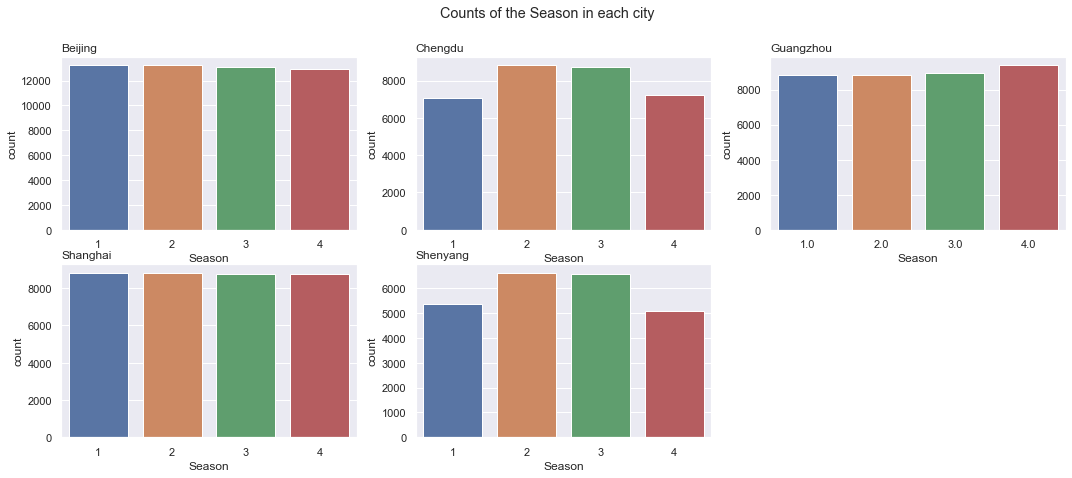

In [12]:
# Column - 'Season'
fig, axs = plt.subplots(2,3,figsize=(18,7))
fig.delaxes(axs[1][2])
fig.suptitle('Counts of the Season in each city')
map1={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(n_cities):
    j,k=map1[i][0],map1[i][1]
    sns.countplot(ax=axs[j,k],x=df_all[i]['Season'])
    axs[j,k].set_title(cityNames[i],loc='left')
plt.show()

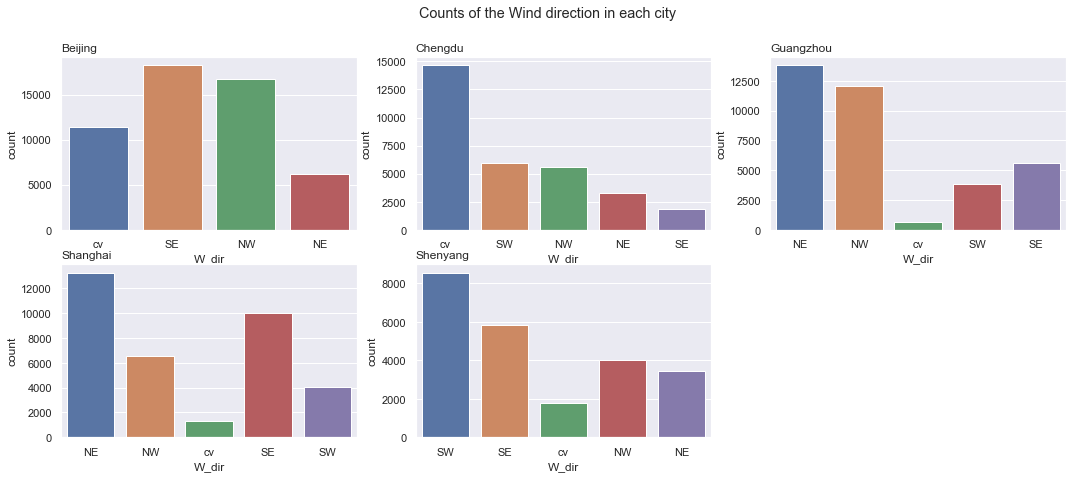

In [13]:
# Column - 'W_dir'
fig, axs = plt.subplots(2,3,figsize=(18,7))
fig.delaxes(axs[1][2])
fig.suptitle('Counts of the Wind direction in each city')
map1={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(n_cities):
    j,k=map1[i][0],map1[i][1]
    sns.countplot(ax=axs[j,k],x=df_all[i]['W_dir'])
    axs[j,k].set_title(cityNames[i],loc='left')
plt.show()

### Plot the distributions of numerical columns in each dataset

In [14]:
num_feat = ['PM2.5','Dew','Humi','Pres','Temp','W_speed','Prec','Prec_cum']
def plot_num_feat(df,city):
    fig, axs = plt.subplots(2,4,figsize=(20,7))
    fig.suptitle('Distribution of all numerical variables in %s'%city)
    for i in range(8):
        j=i//4
        k=i%4
        sns.histplot(ax=axs[j,k],x=df[num_feat[i]],bins=30,kde=True)
        axs[j,k].set_title(city,loc='left')
        axs[j,k].set_xlabel(num_feat[i])
    plt.show()

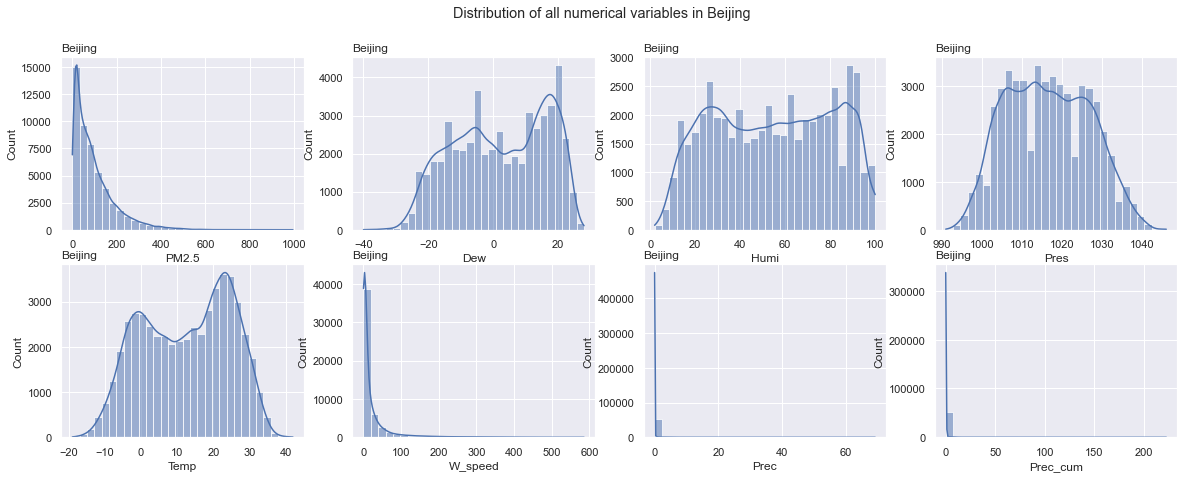

In [15]:
#Beijing
icity=0
plot_num_feat(df_all[icity],cityNames[icity])

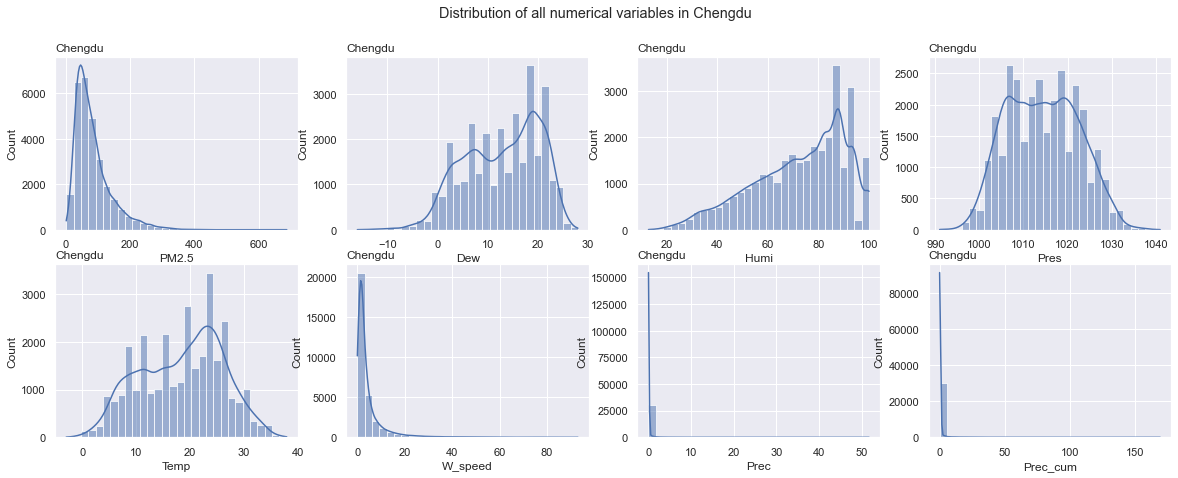

In [16]:
#Chengdu
icity=1
plot_num_feat(df_all[icity],cityNames[icity])

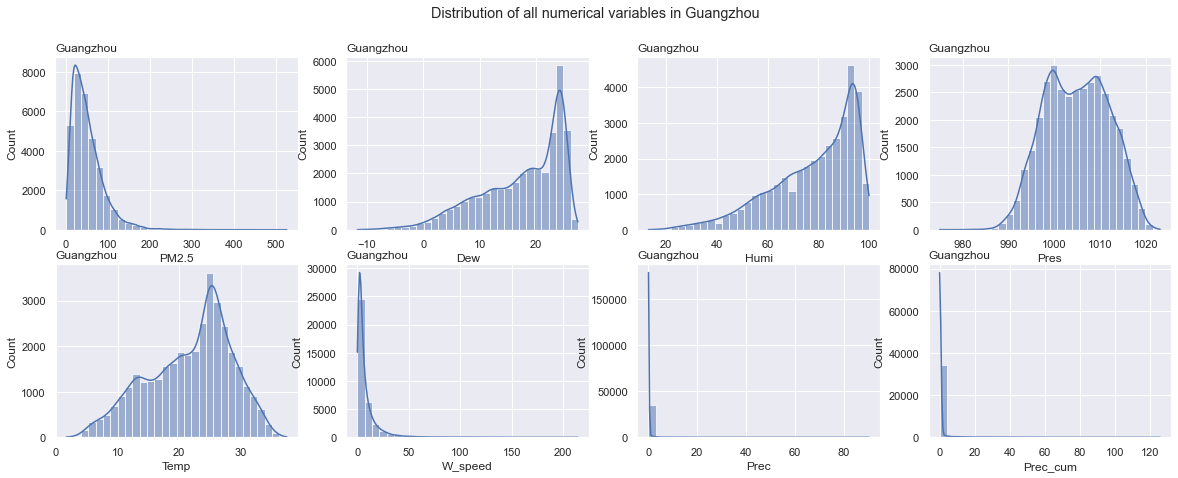

In [17]:
#Guangzhou
icity=2
plot_num_feat(df_all[icity],cityNames[icity])

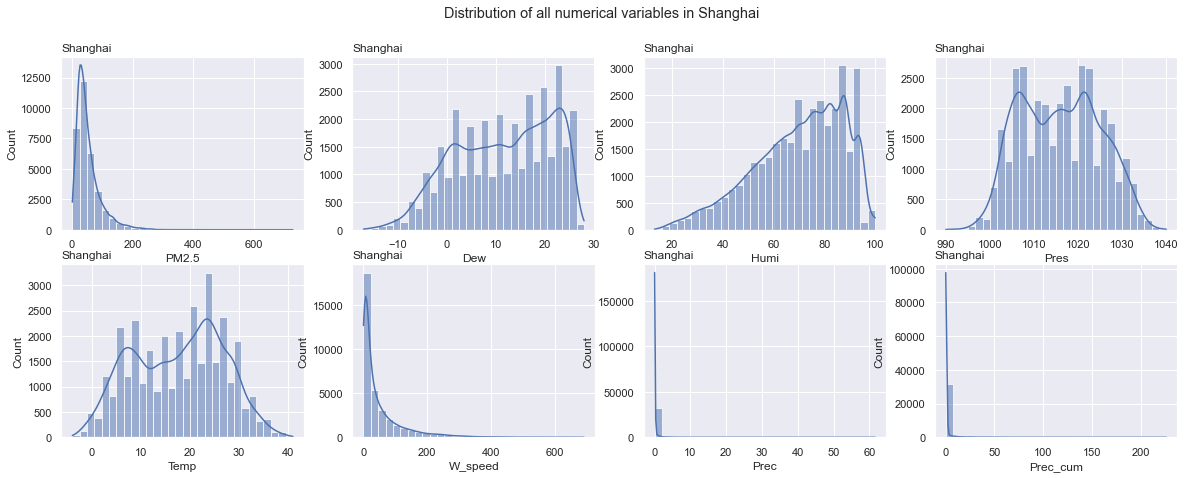

In [18]:
#Shanghai
icity=3
plot_num_feat(df_all[icity],cityNames[icity])

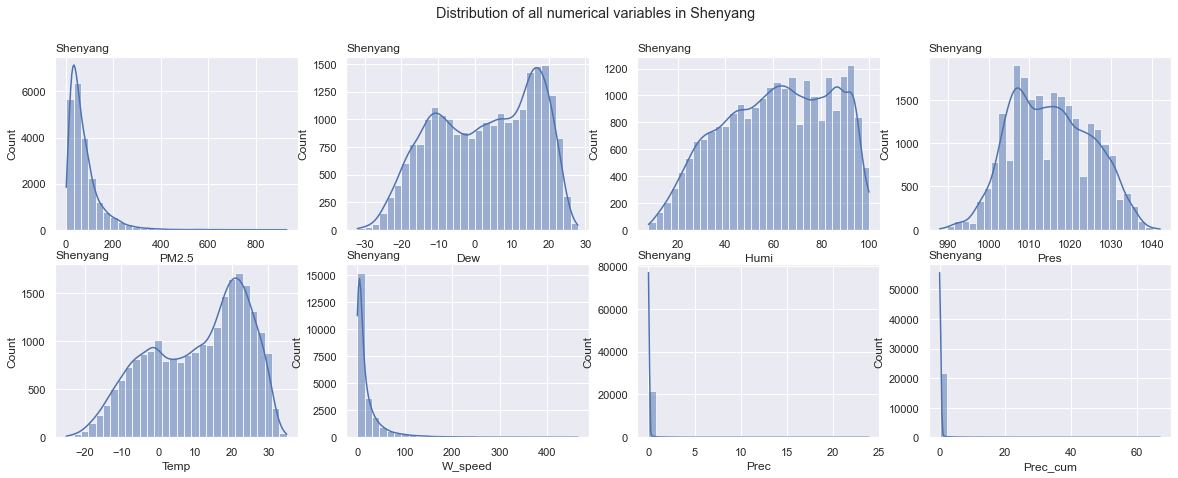

In [19]:
#Shenyang
icity=4
plot_num_feat(df_all[icity],cityNames[icity])

#### Findings -
- Shanghai has comparatively more percentage of high Dew hours than others
- Beijing has comparatively a larger fraction of low-humidity hours
- Shenyang has the coldest temperatures reaching below  -20 degrees

### Boxplots of the columns in each dataset

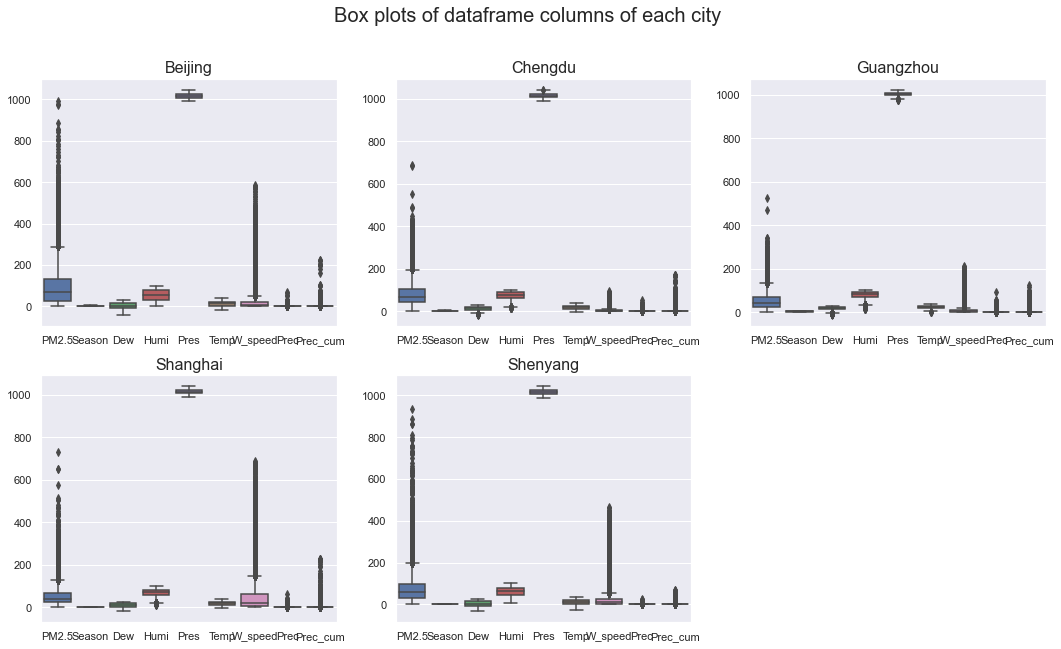

In [20]:
fig, axs = plt.subplots(2,3,figsize=(18,10))
fig.delaxes(axs[1][2])
fig.suptitle('Box plots of dataframe columns of each city',fontsize=20)
map1={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(n_cities):
    j, k = map1[i][0], map1[i][1]
    sns.boxplot(ax=axs[j,k],data=df_all[i])
    axs[j,k].set_title(cityNames[i],fontsize=16)
    #axs[j,k].set_ylim(-100,500)
plt.show()

From the boxplots it is seen that 'PM2.5', 'W_speed', 'Prec' and 'Prec_cum'have skewed distributions with several extreme values away from the quantiles.

### Correlation plots of the columns in Beijing dataset

<Figure size 1080x576 with 0 Axes>

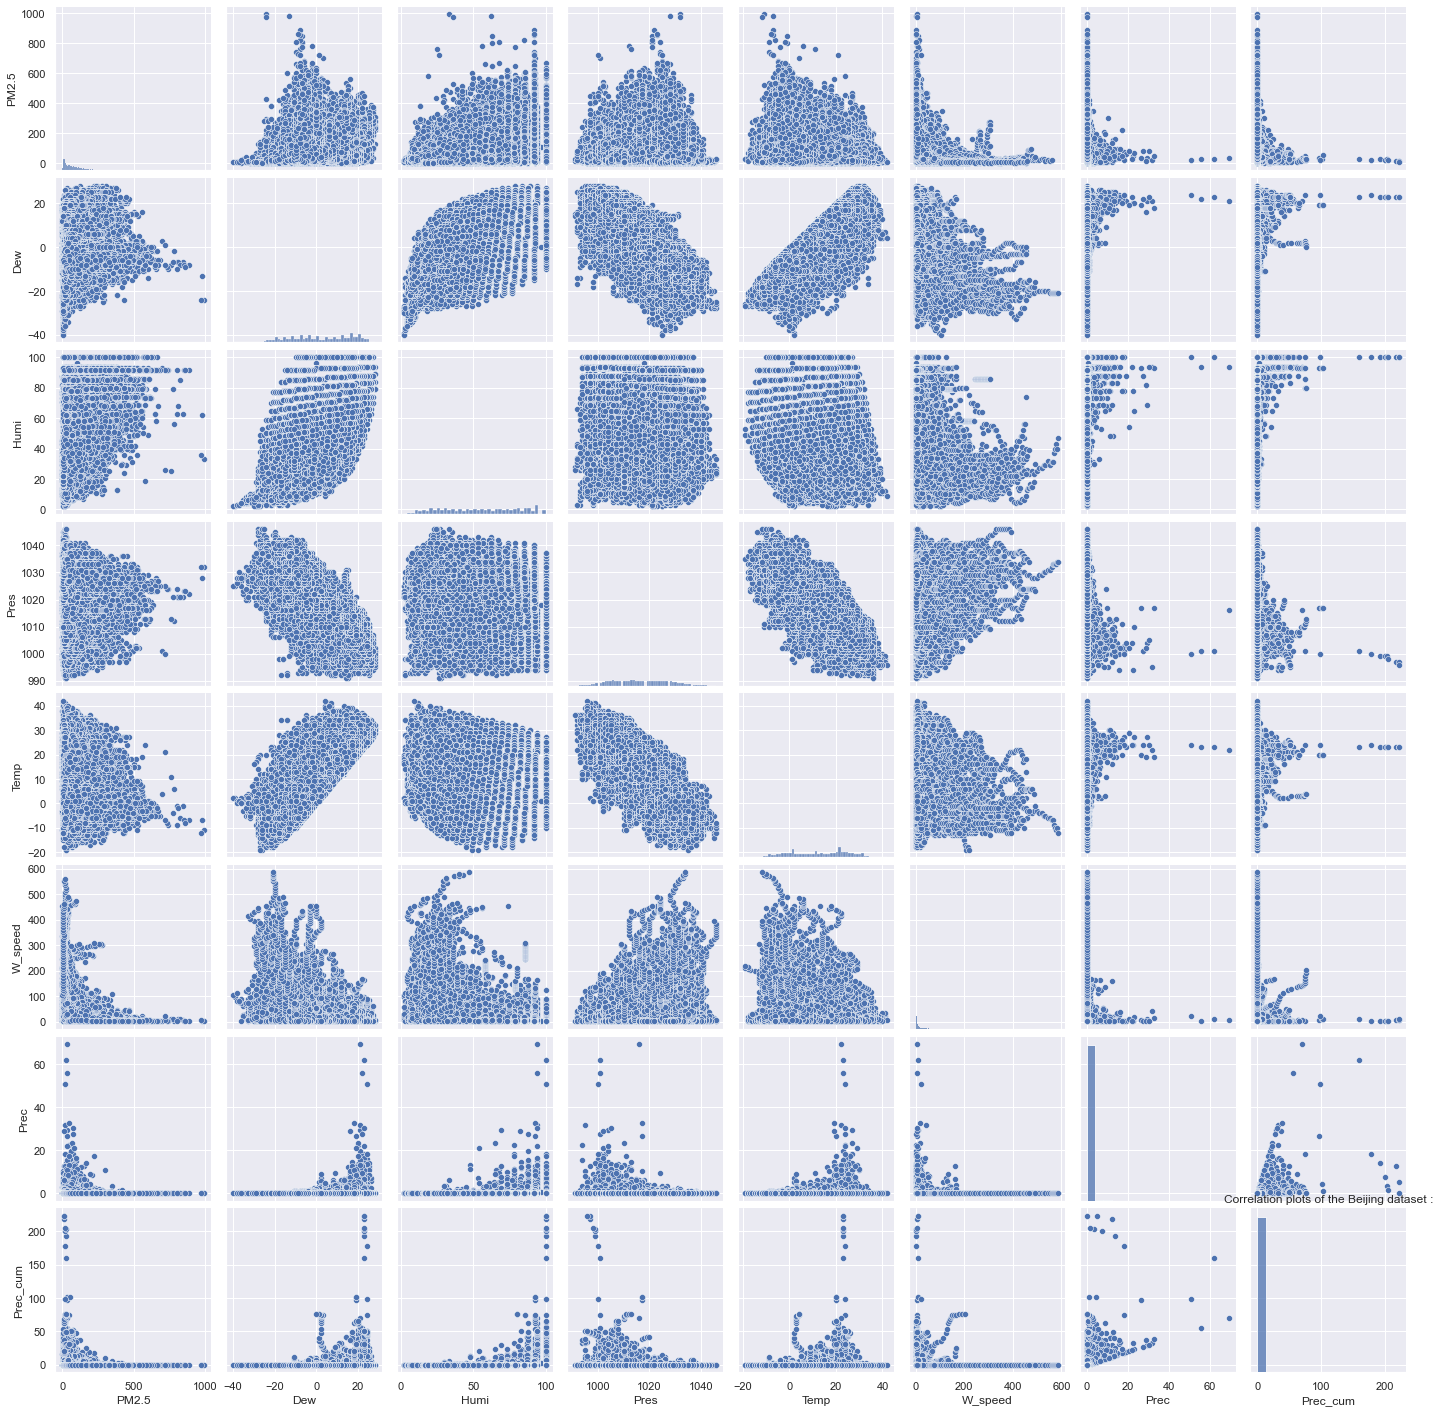

In [21]:
#Correlations
plt.figure(figsize=(15,8)) 
sns.pairplot(df_all[0],vars=num_feat)
plt.title("Correlation plots of the Beijing dataset :")
plt.show()

### Findings from the correlation plots
Based on the plots I can identify the following correlation patterns :
- PM2.5 increases with rise in Humidity.
- PM2.5 increases with fall in Temperature, Wind speed, Precipitation and Cumulative Precipitation.
- Dew decreases with rise in Pressure.
- Dew inreases with rise in Temperature.
- Precipitation increases with rise Dew, Humidity and Temperature
- Precipitation decreases with rise in Pressure and Wind speed.

## 3. Feature Engineering

In [22]:
#Read data
df_all=[]
for i in range(n_cities):
    name = "./data1/data_%d.csv"%(i)
    df_all.append(pd.read_csv(name, index_col=0))

### Handle null values in the datasets
Find the total null values in each column in each dataset

In [23]:
for i in range(n_cities):
    print("\nNull values in data - %s : "%cityNames[i])
    print(df_all[i].isnull().sum())


Null values in data - Beijing : 
PM2.5       2174
Season         0
Dew            5
Humi         339
Pres         339
Temp           5
W_dir          5
W_speed        5
Prec         485
Prec_cum     485
dtype: int64

Null values in data - Chengdu : 
PM2.5       2934
Season         0
Dew          492
Humi         496
Pres         486
Temp         490
W_dir        486
W_speed      498
Prec        1267
Prec_cum    1267
dtype: int64

Null values in data - Guangzhou : 
PM2.5       3683
Season         1
Dew            5
Humi           5
Pres           1
Temp           1
W_dir          1
W_speed        1
Prec           1
Prec_cum       1
dtype: int64

Null values in data - Shanghai : 
PM2.5       1103
Season         0
Dew            5
Humi           5
Pres          20
Temp           5
W_dir          4
W_speed        4
Prec        2272
Prec_cum    2272
dtype: int64

Null values in data - Shenyang : 
PM2.5       1923
Season         0
Dew            2
Humi           2
Pres           2
Temp     

- Replace null values in categorical columns with the mode
- Replace null values in numerical columns with the mean

In [24]:
for df in df_all:
    cols = df.columns.to_list()
    for col in cols:
        if col=='Season' or col=='W_dir':
            df[col].fillna(df[col].mode()[0],inplace=True)
        else:
            df[col].fillna(df[col].mean(),inplace=True)
df_all[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 52561 entries, 2010-01-01 23:00:00 to 2015-12-31 23:00:00
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     52561 non-null  float64
 1   Season    52561 non-null  int64  
 2   Dew       52561 non-null  float64
 3   Humi      52561 non-null  float64
 4   Pres      52561 non-null  float64
 5   Temp      52561 non-null  float64
 6   W_dir     52561 non-null  object 
 7   W_speed   52561 non-null  float64
 8   Prec      52561 non-null  float64
 9   Prec_cum  52561 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 4.4+ MB


### Encode catogorical variable - W_dir
Plot the 'W_dir' distributions in Beijing dataset

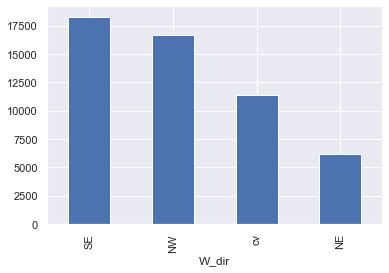

In [25]:
df_all[0]['W_dir'].value_counts().plot(kind='bar',xlabel='W_dir')
plt.show()

Create label encodings for the two categorical columns

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = [LabelEncoder()]*n_cities
cnt=0
for df in df_all:
    df['W_dir']=encoder[cnt].fit_transform(df['W_dir'])
    cnt+1
df_all[0].head()

,PM2.5,Season,Dew,Humi,Pres,Temp,W_dir,W_speed,Prec,Prec_cum
2010-01-01 23:00:00,129.0,4,-17.0,41.0,1020.0,-5.0,3,0.89,0.0,0.0
2010-01-02 00:00:00,148.0,4,-16.0,38.0,1020.0,-4.0,2,1.79,0.0,0.0
2010-01-02 01:00:00,159.0,4,-15.0,42.0,1020.0,-4.0,2,2.68,0.0,0.0
2010-01-02 02:00:00,181.0,4,-11.0,63.5,1021.0,-5.0,2,3.57,0.0,0.0
2010-01-02 03:00:00,138.0,4,-7.0,85.0,1022.0,-5.0,2,5.36,0.0,0.0


In [27]:
# Create one-hot encodings for the two categorical columns
#for i in range(n_cities):
#    df_all[i] = pd.get_dummies(df_all[i],columns=['Season','W_dir'])

### Normalize data
As some features have skewed distributions I am using MinMaxScaler.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = [MinMaxScaler()]*n_cities
data_sc=[]
for i in range(n_cities):
    df_all[i] = df_all[i].astype(float)
    data_sc.append(scaler[i].fit_transform(df_all[i]))

### Prepare data for Time-Series Analysis
I will be using LSTM model for the multivariate time series analysis.\
Preparing the Features and Target datasets for it.\
- Using a window of size 4. The idea is to use 4 rows to predict the 'PM2.5' of the next row.\
- The Features dataset is a consecutive matrix of 4 pairs of the rows in the original dataset with starting point from the first row to the (n-4)th row. 
- The Target dataset is the the 'PM2.5' starting from the 5th row to the last row.
- I am taking a small size of window due to limited computing power

In [29]:
#Function to create Feature and Target using window of size 4
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

Create the Feature(X) and Target(Y) and display the dimensions for each dataset

In [30]:
X=[0]*n_cities
Y=[0]*n_cities
for i in range(n_cities):
    X[i], Y[i] = to_supervised(data_sc[i])
    X[i] = np.array(X[i])
    Y[i] = np.array(Y[i])
    print('Y_%d'%i ,Y[i].shape)
    print('X_%d'%i ,X[i].shape)

Y_0 (52557, 1)
X_0 (52557, 4, 10)
Y_1 (31830, 1)
X_1 (31830, 4, 10)
Y_2 (36031, 1)
X_2 (36031, 4, 10)
Y_3 (35138, 1)
X_3 (35138, 4, 10)
Y_4 (23599, 1)
X_4 (23599, 4, 10)


### Train-Test Split
- Split the datasets into training and testing samples
- The testing samples cover the final year 2015 and the training sample covers the rest.
- The testing sample will be used for model prediction and evaluation.

In [31]:
#Checking if all datasets have the same timestamp of last row
last_dates=[]
for df in df_all:
    last_dates.append(df.index[-1])
last_dates

['2015-12-31 23:00:00',
 '2015-12-31 23:00:00',
 '2015-12-31 23:00:00',
 '2015-12-31 23:00:00',
 '2015-12-31 23:00:00']

In [32]:
#Splitting the dataset
n_test = 24*n_months*30
X_train=[0]*n_cities
y_train=[0]*n_cities
X_test=[0]*n_cities
y_test=[0]*n_cities
for i in range(n_cities):
    print("\n Dataset - %s"%cityNames[i])
    X_train[i], X_test[i] = X[i][:-n_test,] , X[i][-n_test:,]
    print('X_train' ,X_train[i].shape)
    print('X_test' ,X_test[i].shape)

    y_train[i], y_test[i] = Y[i][:-n_test,] , Y[i][-n_test:,]
    print('y_train' ,y_train[i].shape)
    print('y_test' ,y_test[i].shape)


 Dataset - Beijing
X_train (43917, 4, 10)
X_test (8640, 4, 10)
y_train (43917, 1)
y_test (8640, 1)

 Dataset - Chengdu
X_train (23190, 4, 10)
X_test (8640, 4, 10)
y_train (23190, 1)
y_test (8640, 1)

 Dataset - Guangzhou
X_train (27391, 4, 10)
X_test (8640, 4, 10)
y_train (27391, 1)
y_test (8640, 1)

 Dataset - Shanghai
X_train (26498, 4, 10)
X_test (8640, 4, 10)
y_train (26498, 1)
y_test (8640, 1)

 Dataset - Shenyang
X_train (14959, 4, 10)
X_test (8640, 4, 10)
y_train (14959, 1)
y_test (8640, 1)


## 4. Model 
I am using two layers of LSTM with 64 neurons and Relu activation function.\
The final layer is a Dense layer with one 1 neuron for the target 'PM2.5'.\
I have 5 identical models for the 5 cities.

In [33]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [34]:
model = [0]*n_cities
for i in range(n_cities):
    model[i] = Sequential()
    model[i].add(LSTM(64, activation='relu', input_shape=(X_train[i].shape[1], X_train[i].shape[2]), return_sequences=True))
    model[i].add(Dropout(0.2))
    model[i].add(LSTM(64, activation='relu', return_sequences=False))
    model[i].add(Dropout(0.2))
    #model.add(Dense(y_train.shape[1]))
    model[i].add(Dense(units = 1))

    model[i].compile(optimizer='adam', loss='mse')
    #model[i].summary()

## 5. Model Training
Training the models for 10 epochs with batch size of 32 and validation split of 0.1

In [35]:
#Train the model
#model.fit(X_train, y_train, epochs = 10, batch_size = 32, shuffle = False)
history = []
for i in range(n_cities):
    history.append(model[i].fit(X_train[i], y_train[i], epochs=10, batch_size=32, validation_split=0.1, verbose=1, shuffle = False))

Train on 39525 samples, validate on 4392 samples
Epoch 1/10
39525/39525 [==============================] - 30s 749us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 2/10
39525/39525 [==============================] - 26s 660us/step - loss: 0.0016 - val_loss: 8.7035e-04
Epoch 3/10
39525/39525 [==============================] - 26s 659us/step - loss: 0.0012 - val_loss: 6.8004e-04
Epoch 4/10
39525/39525 [==============================] - 29s 724us/step - loss: 0.0010 - val_loss: 6.4271e-04
Epoch 5/10
39525/39525 [==============================] - 26s 660us/step - loss: 9.7594e-04 - val_loss: 6.3392e-04
Epoch 6/10
39525/39525 [==============================] - 98s 2ms/step - loss: 9.4504e-04 - val_loss: 5.5242e-04
Epoch 7/10
39525/39525 [==============================] - 28s 716us/step - loss: 9.1994e-04 - val_loss: 5.4656e-04
Epoch 8/10
39525/39525 [==============================] - 27s 680us/step - loss: 8.9863e-04 - val_loss: 4.9625e-04
Epoch 9/10
39525/39525 [=============================

In [36]:
#Saving model
from keras.models import load_model
for i in range(n_cities):
    model[i].save('./output/Model_%d.h5'%i)

Comparing the Training and Validation loss of the models

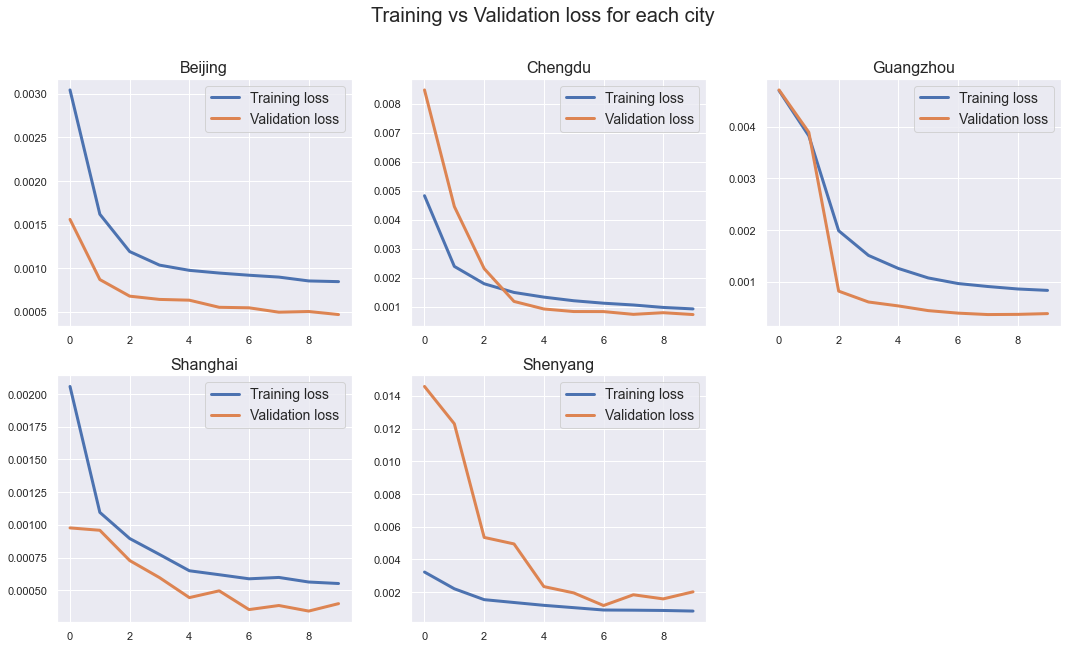

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.delaxes(axs[1][2])
fig.suptitle('Training vs Validation loss for each city',fontsize=20)
map1={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(n_cities):
    j, k = map1[i][0], map1[i][1]
    axs[j,k].plot(history[i].history['loss'],label='Training loss',linewidth=3)
    axs[j,k].plot(history[i].history['val_loss'],label='Validation loss',linewidth=3)
    axs[j,k].set_title(cityNames[i],fontsize=16)
    axs[j,k].legend(fontsize=14)
plt.show()

#### Comments on learning curves :
- In all cases training and validation loss are decreasing
- I have used small number of epochs due to my limitation on computing resources
- In case of Shenyang dataset, the model is underfitting as the training loss is not decreasing much and validation loss is large and bumpy.
- In case of Beijing, Chengdu and Guangzhou the model seems to do be somewhat good fit. Both the losses have decreased and getting closer.
- In case of Shanghai the two curves are slightly diverging so it might be a cas of underfitting.
- All the curves show a gap between training and validation curves. A larger training dataset might help in improving the performance of the model.

## 6. Model Evaluation

Calculated the model predictions.\
Calculated the scaled RMSE.

In [38]:
from sklearn.metrics import mean_squared_error
y_pred=[0]*n_cities
for i in range(n_cities):
    y_pred[i] = model[i].predict(X_test[i])

    mse = mean_squared_error(y_test[i], y_pred[i])
    rmse = np.sqrt(mse)
    print("Scaled RMSE for %s : "%cityNames[i],rmse)

Scaled RMSE for Beijing :  0.024493472010123116
Scaled RMSE for Chengdu :  0.02176817449184751
Scaled RMSE for Guangzhou :  0.018711044834916434
Scaled RMSE for Shanghai :  0.019215898765007223
Scaled RMSE for Shenyang :  0.03441765085547137


Calculated the unscaled prediction and test values.\
Calculated the unscaled RMSE.

In [39]:
y_predicted=[0]*n_cities
y_tested=[0]*n_cities
for i in range(n_cities):
    y_predicted[i] = np.concatenate((y_pred[i],data_sc[i][-y_pred[i].shape[0]:,1:]),axis=1)
    y_tested[i] = np.concatenate((y_test[i],data_sc[i][-y_pred[i].shape[0]:,1:]),axis=1)

    y_predicted[i] = scaler[i].inverse_transform(y_predicted[i])
    y_tested[i] = scaler[i].inverse_transform(y_tested[i])

    y_predicted[i] = y_predicted[i][:,0:1]
    y_tested[i] = y_tested[i][:,0:1]

In [40]:
from sklearn.metrics import mean_squared_error
for i in range(n_cities):
    mse = mean_squared_error(y_tested[i], y_predicted[i])
    rmse = np.sqrt(mse)
    print("Unscaled RMSE for %s : "%cityNames[i],rmse)

Unscaled RMSE for Beijing :  22.80342244142462
Unscaled RMSE for Chengdu :  20.266170451910025
Unscaled RMSE for Guangzhou :  17.4199827413072
Unscaled RMSE for Shanghai :  17.890001750221728
Unscaled RMSE for Shenyang :  32.04283294644384


Compared the predicted with the actual PM2.5 values for the last 100 hours

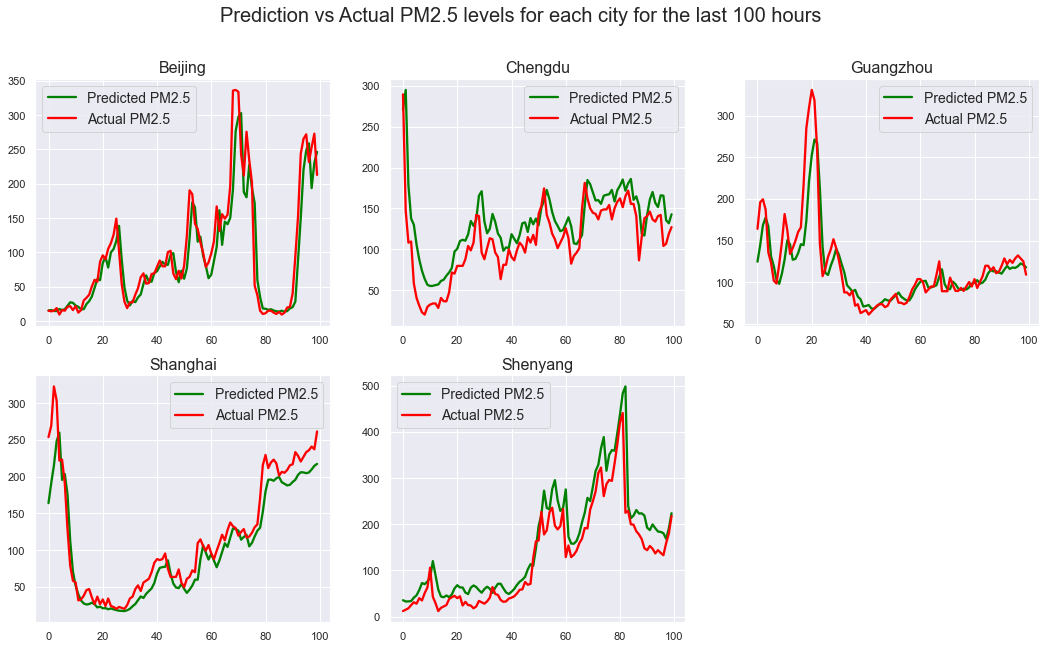

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.delaxes(axs[1][2])
fig.suptitle('Prediction vs Actual PM2.5 levels for each city for the last 100 hours',fontsize=20)
map1={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(n_cities):
    j, k = map1[i][0], map1[i][1]
    axs[j,k].plot(y_predicted[i][:100,:],color='green',linewidth=2.3,label='Predicted PM2.5')
    axs[j,k].plot(y_tested[i][:100,:],color='red',linewidth=2.3,label='Actual PM2.5')
    axs[j,k].set_title(cityNames[i],fontsize=16)
    axs[j,k].legend(fontsize=14)
plt.show()

The predicted values of the last 100 hours seem to be close to the actual values. The models can capture the highs and lows of the PM2.5 levels.

Calculated and ploted the average daily 'PM2.5' levels for the predictions of the year 2015.

In [42]:
def avg_day(inputs):
    out=[]
    s=0
    for i in range(len(inputs)):
        s+=inputs[i]
        if (i+1)%24==0: 
            out.append(s/24.0)
            s=0
    return out

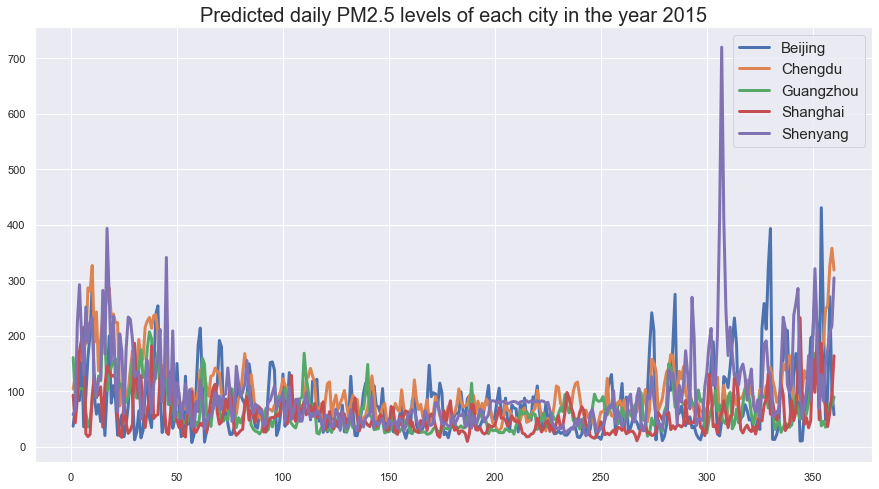

In [43]:
pred_avg_day=[0]*n_cities
plt.figure(figsize=(15,8)) 
for i in range(n_cities):
    pred_month=y_predicted[i][-24*30*n_months:]
    pred_avg_day[i] = avg_day(pred_month)
    plt.plot([j+1 for j in range(30*n_months)],pred_avg_day[i],label=cityNames[i],linewidth=3)
plt.legend(fontsize=15)
plt.title("Predicted daily PM2.5 levels of each city in the year 2015",fontsize=20)
plt.show()

The average daily PM levels are high for all cities mainly in the beginning and end of the years.

## Final comparison of number of days with high pollution levels for each month between cities

In [44]:
def find_highs(days,cut):
    out=[]
    month=0
    s=0
    for i in range(len(days)):
        if days[i] >= cut:
            s+=1
        month+=1
        if month==30:
            out.append(s)
            s=0
            month=0
    return out

In [45]:
high_cut = 150
pred_high_months={}
for i in range(n_cities):
    highs = find_highs(pred_avg_day[i],high_cut)
    pred_high_months[i] = highs
df_high_months = pd.DataFrame(pred_high_months)

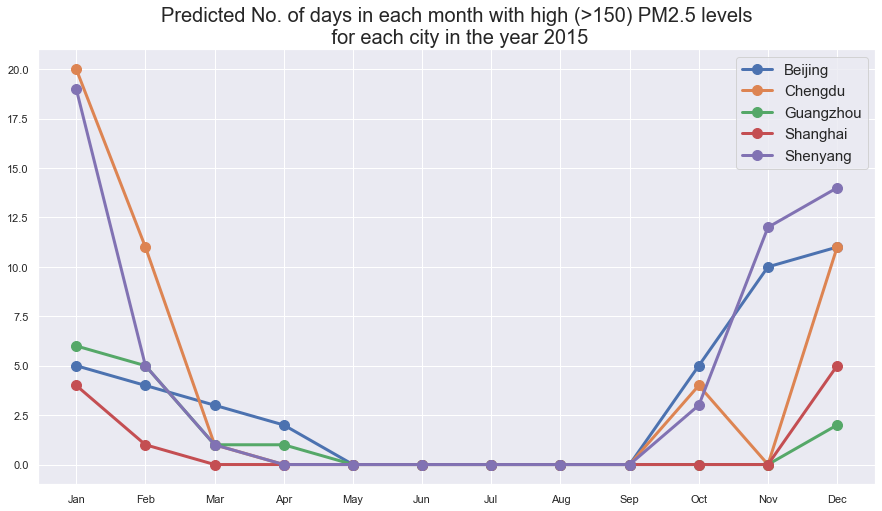

In [46]:
plt.figure(figsize=(15,8)) 
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(n_cities):
    plt.plot(months,pred_high_months[i],label=cityNames[i],linewidth=3,marker='o',markersize=10)
plt.legend(fontsize=15)
plt.title("Predicted No. of days in each month with high (>150) PM2.5 levels\n for each city in the year 2015",fontsize=20)
plt.show()

- With a threshold of PM2.5=150, it is observed that all the cities show larger number of days with high(>150) pollution levels in the winter months of Jan, Feb, Mar, Oct, Nov and Dec. During the summer months the pollution levels are low.
- In the months start of winter in Oct, Nov - Beijing has the highest levels followed by Shenyang.
- As the winter progresses and it becomes colder, Chengdu takes over and becomes the highest polluted followed by Shenyang, Beijing, Guangzhou and Shanghai.
- All these predictions are based on the LSTM modelling and may improve with larger dataset, computing power with GPUS, larger training epochs and more complex models.